<a href="https://colab.research.google.com/github/almilash/sparkasse_text_classification_challenge/blob/main/Sparkasse_Challenge_AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import openpyxl
#!pip install gensim
import gensim
import gensim.corpora as corpora
import nltk
import spacy
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.ensemble import  RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sentence_transformers import SentenceTransformer

## Pre processing

In [ ]:
df = pd.read_excel("20250602_Anfragen_Sample.xlsx")
df_clean = clean_text(df, "Kundenanfrage")
df_clean["Kundenanfrage"] = df_clean["Kundenanfrage"].apply(remove_stopwords_from_series)
df_clean["tokens"] = df_clean["Kundenanfrage"].str.split()
id2word = corpora.Dictionary(df_clean["tokens"])
texts = df_clean["tokens"]
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
nltk.download('stopwords')
stopwords_l = stopwords.words("german")

def tokenize(text):
    nltk.download('stopwords')
    stopwords_l = stopwords.words("german")
    tokens = gensim.utils.simple_preprocess(text, deacc=True)
    tokens = [token for token in tokens if token not in stopwords_l]
    return tokens



def clean_text(df: pd.DataFrame, x : str):

    df[x] = df[x].replace(r"^(.*?),","",regex= True)
    df[x] = df[x].replace(r"(Viele|Mit|Herzliche|Liebe|Beste|Freundliche).*Grüß.*", "", regex=True)
    df[x] = df[x].replace(r"Vielen Dank.*","",regex = True)
    df[x] = df[x].replace(r'[^\s\w]+','',regex = True)
    df[x] = df[x].str.lower()

    return df


def remove_stopwords_from_series(text):
    words = text.split()
    words_filtered = [w for w in words if w not in stopwords_l]
    return " ".join(words_filtered)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_group = pd.DataFrame(df_clean.groupby("Unterkategorie2")["Kundenanfrage"].agg(lambda x: " ".join(x)))

Adressänderung


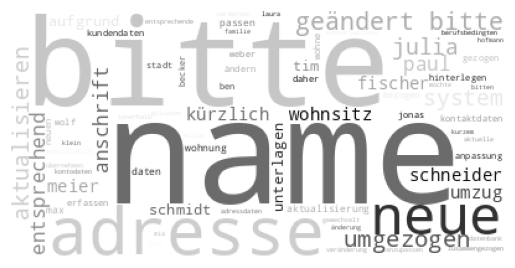

Auslandsbuchung


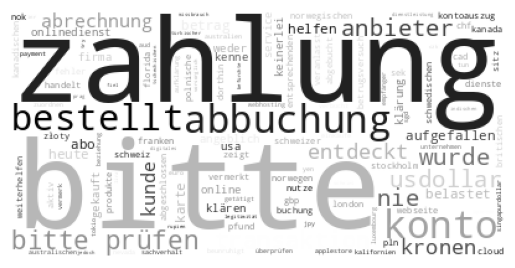

Bearbeitungsdauer


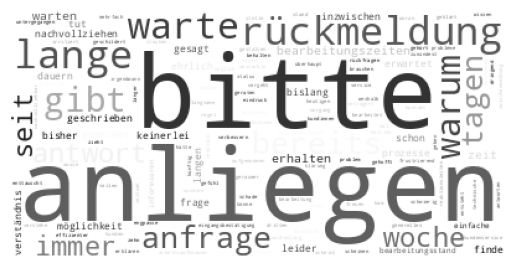

Gebühren


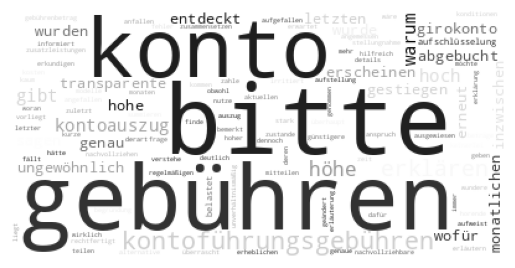

Gerätewechsel


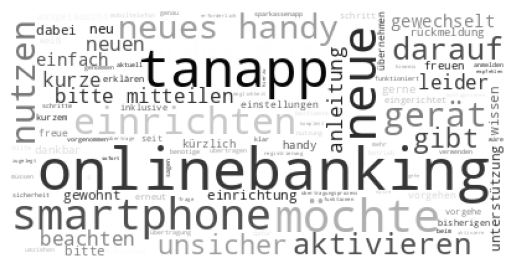

Girokonto


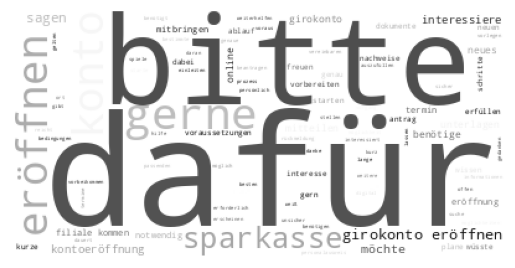

Kreditkarte


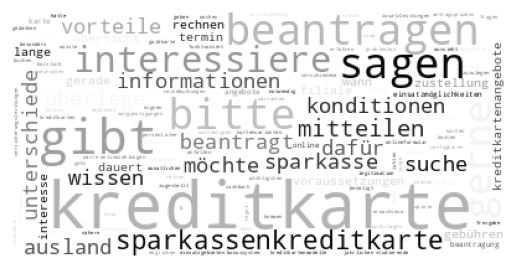

Nachhaltige Geldanlagen


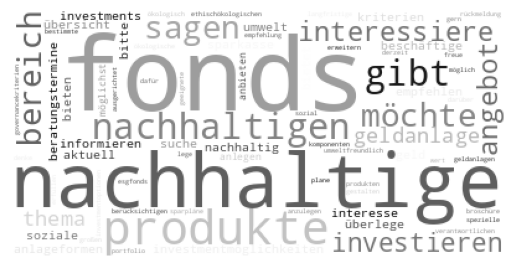

Namensänderung


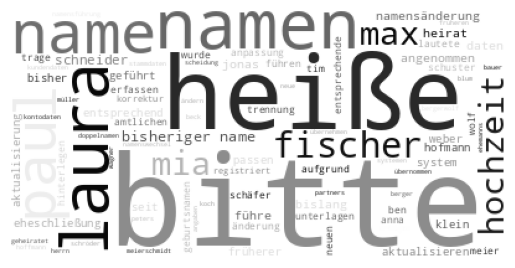

Phishing


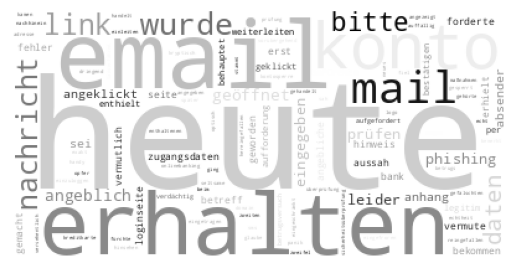

Servicequalität


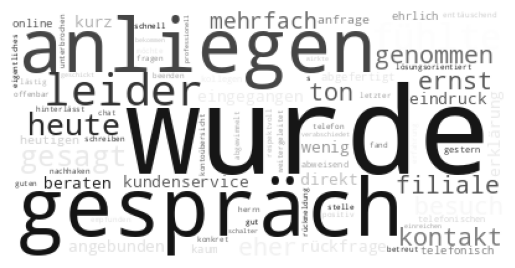

TAN-Verfahren


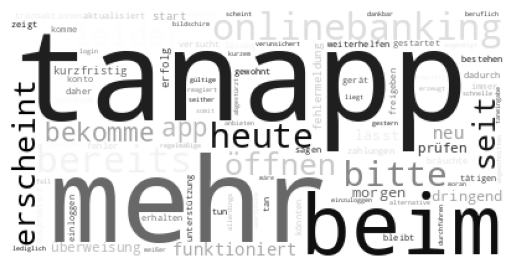

In [ ]:
wordcloud_dic = {}
for index,row in df_group.iterrows():
    wc = WordCloud(background_color='white', colormap = 'binary').generate(row["Kundenanfrage"])
    wordcloud_dic[index] = wc
for k,v in wordcloud_dic.items():
    print(k)
    plt.axis("off")
    plt.imshow(v)
    plt.show()

## LDA

In [ ]:
df_clean["encoded_categories"] = LabelEncoder().fit_transform(df_clean["Unterkategorie2"])
n_topics = [3,6,9,12]
alphas = [0.75,1]
betas = [0.1,0.5]
parameters_RF = {'max_depth':[25],
                 'max_samples':[0.6],
                 'max_features':[9]}
df_score = pd.DataFrame({'alpha':[],'beta':[],'n_topics' :[],'max_depth' : [], 'max_features':[], 'max_samples':[],'accuracy':[]})

for a in alphas:
    for b in betas:
        for n in n_topics:
            lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=n,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha = a,
                                                eta = b,
                                                per_word_topics=False)
            topics = lda_model.print_topics(num_words=10)
            t = lda_model.get_document_topics(corpus,minimum_probability=0)
            columns = []
            for i in range(0,n):
                df[f"topic_{i}"] = [t[d][i][1] for d in range(0,len(t))]
                columns.append(f"topic_{i}")
            X = df[columns]
            y = df['encoded_categories']
            X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42)

            #Random Forest
            RF = RandomForestClassifier()

            #Hyperparameter Tuning ausführen
            CV_RF = GridSearchCV(RF,
                                parameters_RF,
                                scoring = 'accuracy',
                                cv = 10)

            #Mit dem Trainingsatz trainieren
            CV_RF.fit(X_train,y_train)
            print(CV_RF.best_score_)
            #Feature importances anzeigen
            print(CV_RF.best_estimator_.feature_importances_)
            y_pred_RF = CV_RF.predict(X_test)
            #Accuracy-Wert für den Testsatz speichern
            RF_score = accuracy_score(y_test,y_pred_RF)
            df_score2 = pd.DataFrame({'alpha':[a],'beta':[b], 'n_topics' : [n],
                                    'max_depth' : [CV_RF.best_estimator_.get_params()["max_depth"]],
                                    'max_features':[CV_RF.best_estimator_.get_params()["max_features"]],
                                    'max_samples':[CV_RF.best_estimator_.get_params()["max_samples"]],
                                    'accuracy':[RF_score]})
            df_score = pd.concat([df_score,df_score2],axis = 0)


0.4681578947368421
[0.36758237 0.28011353 0.3523041 ]
0.5481578947368421
[0.23966843 0.13819804 0.15585627 0.13326677 0.21908939 0.1139211 ]
0.613421052631579
[0.17312893 0.09262213 0.07989046 0.04961811 0.15819857 0.1052588
 0.0933232  0.15118998 0.09676981]
0.6684210526315789
[0.18375344 0.05044963 0.07005116 0.04160529 0.13699141 0.06680413
 0.0952462  0.0876842  0.04048547 0.06775987 0.10691278 0.05225642]
0.40131578947368424
[0.43386782 0.25186456 0.31426762]
0.593157894736842
[0.25046595 0.1011195  0.14189115 0.17879695 0.23929701 0.08842944]
0.618421052631579
[0.19772862 0.10165919 0.09517703 0.06794161 0.16058808 0.06760602
 0.08728138 0.17546568 0.04655238]
0.6478947368421053
[0.19174681 0.0827814  0.06745945 0.03575255 0.09734706 0.13130755
 0.05725306 0.12009846 0.02776882 0.02902463 0.12850902 0.03095117]
0.44236842105263163
[0.36108453 0.29423597 0.3446795 ]
0.5481578947368422
[0.25917168 0.12814031 0.13432037 0.13141029 0.20521425 0.14174309]
0.6386842105263157
[0.1903598

In [ ]:
best_result = df_score.loc[df_score['accuracy'].idxmax()]
print("Best Accuracy Run:\n")
print(best_result)

Best Accuracy Run:

   alpha  beta  n_topics  max_depth  max_features  max_samples  accuracy
0   0.75   0.1       3.0       25.0           9.0          0.6      0.54
0   0.75   0.1       6.0       25.0           9.0          0.6      0.54
0   0.75   0.1       9.0       25.0           9.0          0.6      0.56
0   0.75   0.1      12.0       25.0           9.0          0.6      0.58
0   0.75   0.5       3.0       25.0           9.0          0.6      0.44
0   0.75   0.5       6.0       25.0           9.0          0.6      0.62
0   0.75   0.5       9.0       25.0           9.0          0.6      0.60
0   0.75   0.5      12.0       25.0           9.0          0.6      0.60
0   1.00   0.1       3.0       25.0           9.0          0.6      0.42
0   1.00   0.1       6.0       25.0           9.0          0.6      0.52
0   1.00   0.1       9.0       25.0           9.0          0.6      0.68
0   1.00   0.1      12.0       25.0           9.0          0.6      0.68
0   1.00   0.5       3.0       

In [ ]:
# Model LDA with Naive Bayes

df_clean["encoded_categories"] = LabelEncoder().fit_transform(df_clean["Unterkategorie2"])

n_topics = [3, 6, 9, 12]
alphas = [0.75, 1]
betas = [0.1, 0.5]

df_score = pd.DataFrame({'alpha': [], 'beta': [], 'n_topics': [], 'accuracy': []})

for a in alphas:
    for b in betas:
        for n in n_topics:
            lda_model = gensim.models.ldamodel.LdaModel(
                corpus=corpus,
                id2word=id2word,
                num_topics=n,
                random_state=100,
                update_every=1,
                chunksize=100,
                passes=10,
                alpha=a,
                eta=b,
                per_word_topics=False
            )

            t = lda_model.get_document_topics(corpus, minimum_probability=0)
            columns = []
            for i in range(n):
                df[f"topic_{i}"] = [t[d][i][1] for d in range(len(t))]
                columns.append(f"topic_{i}")

            X = df[columns]
            y = df['encoded_categories']

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42
            )

            # Naive Bayes
            NB = MultinomialNB()
            NB.fit(X_train, y_train)
            y_pred_NB = NB.predict(X_test)
            NB_score = accuracy_score(y_test, y_pred_NB)

            df_score2 = pd.DataFrame({
                'alpha': [a],
                'beta': [b],
                'n_topics': [n],
                'accuracy': [NB_score]
            })

            df_score = pd.concat([df_score, df_score2], axis=0, ignore_index=True)

# Show best result
best_result = df_score.loc[df_score['accuracy'].idxmax()]
print("Best configuration:\n", best_result)

Best configuration:
 alpha       0.75
beta        0.50
n_topics    6.00
accuracy    0.32
Name: 5, dtype: float64


## TF-IDF Vectorization

In [ ]:
# TF-IDF Vectorization with Logistic Regression
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),  # unigrams + bigrams
    min_df=2,            # ignore rare words
    max_df=0.9           # ignore too common
)
X = vectorizer.fit_transform(df_clean["Kundenanfrage"])
y = df_clean["Unterkategorie2"]

# Encode labels
y_encoded = LabelEncoder().fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Hyperparameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization strength
    'penalty': ['l2'],
    'solver': ['liblinear'],  # liblinear works well for small-medium sparse data
    'class_weight': [None, 'balanced']
}

# Grid search with 5-fold cross-validation
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Best estimator
best_lr = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# Predict & evaluate
y_pred = best_lr.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("Accuracy:", acc)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best parameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.98

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        10
           2       1.00      0.83      0.91         6
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         3

    accuracy                           0.98        50
   macro avg       0.97      0.99      0.98        50
weighted avg       0.99      0.98      0.98        50


In [ ]:
# TF-IDF Vectorization with XG Boost
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),  # unigrams + bigrams
    min_df=2,            # ignore rare words
    max_df=0.9           # ignore too common
)
X = vectorizer.fit_transform(df_clean["Kundenanfrage"])
y = df_clean["Unterkategorie2"]

# Encode labels
y_encoded = LabelEncoder().fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Hyperparameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.3],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'use_label_encoder': [False],
    'eval_metric': ['mlogloss']  # Avoids warning
}

# Grid search
xgb = XGBClassifier(random_state=42, verbosity=0)
grid = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Best estimator
best_xgb = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# Predict & evaluate
y_pred = best_xgb.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("Accuracy:", acc)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best parameters: {'colsample_bytree': 0.8, 'eval_metric': 'mlogloss', 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8, 'use_label_encoder': False}
Accuracy: 0.84

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.90      0.90      0.90        10
           2       1.00      1.00      1.00         6
           3       0.67      1.00      0.80         2
           4       0.86      0.75      0.80         8
           5       0.80      1.00      0.89         4
           6       1.00      0.67      0.80         3
           7       1.00      0.67      0.80         3
           8       0.67      1.00      0.80         2
           9       1.00      0.80      0.89         5
          10       0.33      0.50      0.40         2
          11       0.67      0.67      0.67         3

    accuracy                           0.84        50
   macro avg       0.82     

In [ ]:
# TF-IDF Vectorization with Support Vector Machiene
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),  # unigrams + bigrams
    min_df=2,
    max_df=0.9
)
X = vectorizer.fit_transform(df_clean["Kundenanfrage"])
y = df_clean["Unterkategorie2"]

# Encode labels
y_encoded = LabelEncoder().fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# Hyperparameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],  # 'linear' is often best for text data
    'class_weight': [None, 'balanced']
}

# Grid search
svc = SVC()
grid = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Best estimator
best_svm = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# Predict & evaluate
y_pred = best_svm.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("Accuracy:", acc)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best parameters: {'C': 10, 'class_weight': None, 'kernel': 'linear'}
Accuracy: 0.98

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        10
           2       1.00      0.83      0.91         6
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         3

    accuracy                           0.98        50
   macro avg       0.97      0.99      0.98        50
weighted avg       0.99      0.98      0.98        50



## BERT

In [ ]:
# 1. Load BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Compact and fast

# 2. BERT embeddings
X = model.encode(df_clean["Kundenanfrage"].tolist(), show_progress_bar=True)

# 3. Encode labels
y = LabelEncoder().fit_transform(df_clean["Unterkategorie2"])

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Set parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

# 6. Grid Search with CV
grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# 7. Fit model
grid.fit(X_train, y_train)

# 8. Evaluate
print("🔍 Best Parameters:", grid.best_params_)
best_rf = grid.best_estimator_

y_pred = best_rf.predict(X_test)
print("\n✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Fitting 5 folds for each of 24 candidates, totalling 120 fits
🔍 Best Parameters: {'class_weight': None, 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 200}

✅ Accuracy: 0.7

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      0.10      0.18        10
           2       0.75      1.00      0.86         6
           3       0.33      0.50      0.40         2
           4       0.89      1.00      0.94         8
           5       0.50      1.00      0.67         4
           6       0.60      1.00      0.75         3
           7       0.67      0.67      0.67         3
           8       1.00      1.00      1.00         2
           9       0.80      0.80      0.80         5
          10       1.00      0.50      0.67         2
          11       1.00      0.33      0.50         3

    accuracy                           0.70        50
   macro avg       0.75      0.7